In [1]:
import os
import sys
working_dir = os.path.join(os.getcwd().split("Text2BGAudio")[0],'Text2BGAudio')
sys.path.append(working_dir)
os.chdir(working_dir)
from datasets import load_dataset
from transformers import ClapModel, ClapProcessor
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
from collections import Counter,defaultdict
from tqdm import tqdm
from Dataset_Creation import audio_dataset
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt

if torch.cuda.is_available():
    DEVICE = torch.device("cuda:0")
    print("Device Name:", torch.cuda.get_device_name(DEVICE))
else:
    DEVICE = torch.device("cpu")
    print("Device Name: CPU")

CLAP_ARCH = "laion/larger_clap_music"


c:\Users\amitmils\Documents\Repo\Text2BGAudio\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device Name: NVIDIA GeForce RTX 4080 SUPER


In [12]:
class EmbeddedDataset(Dataset):
    def __init__(self, embedded_data):
        self.embedded_data = embedded_data
    def __len__(self):
        return len(self.embedded_data)
    def __getitem__(self, idx):
        x,y= self.embedded_data[idx]
        return x,y

criterion = torch.nn.CrossEntropyLoss()
class MLPHead(torch.nn.Module):
    def __init__(self, input_dim=512, output_dim=6, hidden_dim=256):
        super(MLPHead, self).__init__()
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(input_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, output_dim),
            torch.nn.Softmax(dim=1)
        )
    
    def forward(self, x):
        return self.mlp(x)
    
label_to_index  = {'anger' : 0, 'joy' : 1, 'love' : 2, 'sadness' : 3, 'fear' : 4, 'surprise' : 5}
index_to_label = {v: k for k, v in label_to_index.items()}

In [20]:
def create_embedded_ds_v2(dataset,clap_model,processor):
    embedded_data = list()
    with torch.no_grad():
        data_loader = DataLoader(dataset, batch_size=32, shuffle=True)
        for batch in tqdm(data_loader,desc="Batches"):
            audio = batch[0]
            labels = list(batch[1])
            unique_labels = list(set(labels))
            inputs = processor(
                text=unique_labels,
                audios=audio.numpy(),
                return_tensors="pt",
                sampling_rate=48000,
                padding=True,
            )
            inputs = {k: v.to(DEVICE) for k, v in inputs.items()}
            outputs = clap_model(**inputs)
            audio_embeds = outputs.audio_embeds
            embedded_data.extend([(audio_embed.cpu().detach(), label_to_index[label]) for audio_embed, label in zip(audio_embeds, labels)])
    return EmbeddedDataset(embedded_data)

## Load Data

In [ ]:
dataset_path = r"_Data\Music\Music Data New\music_dataset_test_Music Data New_tr3204_val398_te405.pt"
train_data, val_data, test_data = list(torch.load(dataset_path, weights_only=False).values())
train_dataset = audio_dataset.AudioDataset(train_data)
val_dataset = audio_dataset.AudioDataset(val_data)

## Train MLP Head on CLAP

### Create embedded DS

In [ ]:
clap_model_path = r"CLAP\models\clap_fine_tunned_BatchSize_32_LR_1e-05_Epochs_400_VAL_LOSS_25.99.pt"
clap_model = ClapModel.from_pretrained(CLAP_ARCH).to(DEVICE)
processor = ClapProcessor.from_pretrained(CLAP_ARCH)
if clap_model_path is not None:
    clap_model.load_state_dict(torch.load(clap_model_path,weights_only=False)['model_state_dict'])

In [ ]:
train_dataset_embedded = create_embedded_ds_v2(train_dataset,clap_model,processor)
val_dataset_embedded = create_embedded_ds_v2(val_dataset,clap_model,processor)


Batches: 100%|██████████| 13/13 [00:06<00:00,  1.92it/s]


### Train HEAD

Epoch 1/100, Loss: 1.368591070175171, Train Acc : 0.9144818976279651 , Val Acc : 0.7211055276381909
Epoch 2/100, Loss: 1.301470160484314, Train Acc : 0.9847066167290887 , Val Acc : 0.7311557788944724
Epoch 3/100, Loss: 1.0498682260513306, Train Acc : 0.985330836454432 , Val Acc : 0.7386934673366834
Epoch 4/100, Loss: 1.045634150505066, Train Acc : 0.9856429463171036 , Val Acc : 0.7386934673366834
Epoch 5/100, Loss: 1.0744826793670654, Train Acc : 0.985330836454432 , Val Acc : 0.7361809045226131
Epoch 6/100, Loss: 1.047248363494873, Train Acc : 0.9847066167290887 , Val Acc : 0.7361809045226131
Epoch 7/100, Loss: 1.0440610647201538, Train Acc : 0.985330836454432 , Val Acc : 0.7311557788944724
Epoch 8/100, Loss: 1.0444449186325073, Train Acc : 0.985330836454432 , Val Acc : 0.7336683417085427
Epoch 9/100, Loss: 1.0449918508529663, Train Acc : 0.9859550561797753 , Val Acc : 0.7311557788944724
Epoch 10/100, Loss: 1.0444515943527222, Train Acc : 0.9856429463171036 , Val Acc : 0.73115577889447

Text(0, 0.5, 'Accuracy')

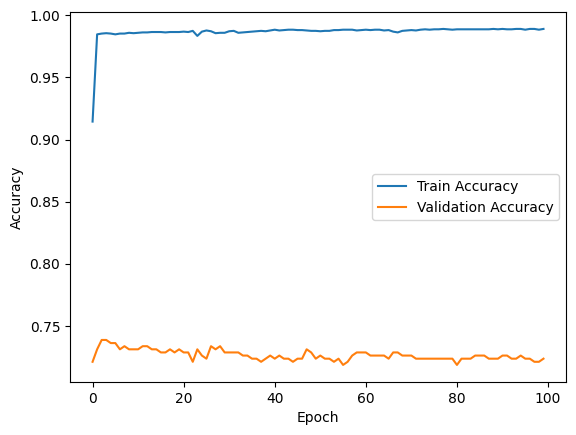

In [19]:
batch_size = 128
epochs = 100
train_data_loader = DataLoader(train_dataset_embedded, batch_size=batch_size, shuffle=True)
val_data_loader = DataLoader(val_dataset_embedded, batch_size=batch_size, shuffle=True)

classification_head = MLPHead().to(DEVICE)
optimizer = torch.optim.Adam(classification_head.parameters(), lr=1e-3)

train_acc = list()
val_acc = list()
for e in range(epochs):
    train_correct = 0
    for batch in train_data_loader:
        audio_embeds, labels = batch
        audio_embeds = audio_embeds.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = classification_head(audio_embeds)
        est_classification = torch.argmax(outputs, dim=1)
        train_correct += torch.sum(est_classification == labels).item()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    train_acc.append(train_correct/len(train_dataset))
    with torch.no_grad():
        val_correct = 0
        for batch in val_data_loader:
            audio_embeds, labels = batch
            audio_embeds = audio_embeds.to(DEVICE)
            labels = labels.to(DEVICE)
            outputs = classification_head(audio_embeds)
            est_classification = torch.argmax(outputs, dim=1)
            val_correct += torch.sum(est_classification == labels).item()
        val_acc.append(val_correct/len(val_dataset))
    print(f"Epoch {e+1}/{epochs}, Loss: {loss.item()}, Train Acc : {train_acc[-1]} , Val Acc : {val_acc[-1]}")

plt.plot(range(epochs), train_acc, label='Train Accuracy')
plt.plot(range(epochs), val_acc, label='Validation Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')


### Train CLAP and MLP together

In [9]:
train_data, val_data, test_data = list(torch.load(r"_Data\Music\Music Data New\music_dataset_test_Music Data New_tr3204_val398_te405.pt", weights_only=False).values())
train_dataset = audio_dataset.AudioDataset(train_data)
val_dataset = audio_dataset.AudioDataset(val_data)

In [11]:

# Load the model and processor
clap_model_path = r"CLAP\models\clap_fine_tunned_BatchSize_32_LR_1e-05_Epochs_400_VAL_LOSS_25.99.pt"
processor = ClapProcessor.from_pretrained(CLAP_ARCH)
clap_model = ClapModel.from_pretrained(CLAP_ARCH).to(DEVICE)
clap_model.load_state_dict(torch.load(clap_model_path, weights_only=False)['model_state_dict'])

# Initialize the MLP head
MLP_HEAD = MLPHead().to(DEVICE)
for param in clap_model.parameters():
    param.requires_grad = False
# Unfreeze audio projection heads
# for param in clap_model.audio_projection.parameters():
#     param.requires_grad = True

# Hyperparameters
epochs = 50
batch_size = 128

# Data loaders
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_data_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

# Optimizer
optimizer = torch.optim.AdamW(
    [
        # {'params': clap_model.parameters(), 'lr': 1e-5},
        {'params': MLP_HEAD.parameters(), 'lr': 1e-3}
    ]
)

# Criterion
criterion = torch.nn.CrossEntropyLoss()

# Accuracy lists
acc_list = {"train": [], "val": []}

# Training loop
for e in range(epochs):
    clap_model.train()
    MLP_HEAD.train()
    train_correct = 0
    total_loss = 0
    for batch in tqdm(train_data_loader, desc="Train Batches"):
        audio = batch[0]
        train_labels = list(batch[1])
        unique_labels = train_labels[:1]  # Not needed for inference
        inputs = processor(
            text=unique_labels,
            audios=audio.numpy(),
            return_tensors="pt",
            sampling_rate=48000,
            padding=True,
        )
        inputs = {k: v.to(DEVICE) for k, v in inputs.items()}
        outputs = clap_model(**inputs)
        audio_embeds = outputs.audio_embeds
        outputs = MLP_HEAD(audio_embeds)
        est_classification = torch.argmax(outputs, dim=1)
        train_correct += torch.sum(est_classification == torch.tensor([label_to_index[label] for label in train_labels]).to(DEVICE)).item()
        loss = criterion(outputs, torch.tensor([label_to_index[label] for label in train_labels]).to(DEVICE))
        total_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_acc = train_correct / len(train_dataset)
    acc_list['train'].append(train_acc)
    
    clap_model.eval()
    MLP_HEAD.eval()
    val_correct = 0
    with torch.no_grad():
        for batch in tqdm(val_data_loader,desc="Val Batches"):
            audio = batch[0]
            val_labels = list(batch[1])
            unique_labels = val_labels[:1]
            inputs = processor(
                text=unique_labels,
                audios=audio.numpy(),
                return_tensors="pt",
                sampling_rate=48000,
                padding=True,
            )
            inputs = {k: v.to(DEVICE) for k, v in inputs.items()}
            outputs = clap_model(**inputs)
            audio_embeds = outputs.audio_embeds
            outputs = MLP_HEAD(audio_embeds)
            est_classification = torch.argmax(outputs, dim=1)
            val_correct += torch.sum(est_classification == torch.tensor([label_to_index[label] for label in val_labels]).to(DEVICE)).item()
    val_acc = val_correct / len(val_dataset)
    acc_list['val'].append(val_acc)
    
    print(f"Epoch {e+1}/{epochs}, Loss: {total_loss / len(train_data_loader)}, Train Acc: {train_acc}, Val Acc: {val_acc}\n")

# Print final accuracies
print("Final Training Accuracy:", acc_list['train'][-1])
print("Final Validation Accuracy:", acc_list['val'][-1])

Val Batches: 100%|██████████| 4/4 [00:07<00:00,  1.88s/it]


Epoch 1/50, Loss: 1.6499157135303204, Train Acc: 0.8957553058676654, Val Acc: 0.7110552763819096



Val Batches: 100%|██████████| 4/4 [00:07<00:00,  1.88s/it]


Epoch 2/50, Loss: 1.2202240549601042, Train Acc: 0.968789013732834, Val Acc: 0.7311557788944724



Val Batches: 100%|██████████| 4/4 [00:07<00:00,  1.88s/it]


Epoch 3/50, Loss: 1.1048855414757361, Train Acc: 0.980649188514357, Val Acc: 0.7261306532663316



Val Batches: 100%|██████████| 4/4 [00:07<00:00,  1.88s/it]


Epoch 4/50, Loss: 1.0942373780103831, Train Acc: 0.9778401997503121, Val Acc: 0.7361809045226131



Val Batches: 100%|██████████| 4/4 [00:07<00:00,  1.88s/it]


Epoch 5/50, Loss: 1.0874333198253925, Train Acc: 0.9809612983770287, Val Acc: 0.7437185929648241



Val Batches: 100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


Epoch 6/50, Loss: 1.0764143054301922, Train Acc: 0.9759675405742821, Val Acc: 0.7412060301507538



Train Batches:  50%|█████     | 13/26 [00:31<00:31,  2.40s/it]


KeyboardInterrupt: 